# Binary Classification of the "Don't Patronize Me!" Dataset

Perform Binary Classification to predict whether a text contains patronizing and condescending language. The task was task 4 (subtask 1) in the SemEval 2022 competition.

## == Initialize Environment == 

In [1]:
# Library imports
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt    

from nltk import PorterStemmer, WordNetLemmatizer
import codecs

import torch
from torch.utils.data import DataLoader, Dataset, Sampler
from tqdm import tqdm
import torch.nn as nn

import re
from functools import partial

import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support

# Pre-trained models
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from transformers import Trainer, TrainingArguments
from transformers import BertTokenizer
from transformers import BertPreTrainedModel, BertModel
from transformers.models.bert.modeling_bert import BertOnlyMLMHead
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler


def fix_seed(seed=420.69):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
#   np.random.seed(seed)
#   random.seed(seed)

fix_seed()

data_path = '../bin/data'
embeddings_path = '../bin/word_embeddings'
model_save_path = '../bin/models'

from util.datafunctions import *
from util.evaluation import *

if not torch.cuda.is_available():
  DEVICE = 'cpu'
else:
  DEVICE = 'cuda'

DEVICE

2024-03-03 22:31:34.838732: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-03 22:31:34.860778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 22:31:34.860804: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 22:31:34.861407: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 22:31:34.865726: I tensorflow/core/platform/cpu_feature_guar

'cuda'

## === Utils ===

### Data related util functions

In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def generate_data_splits(train_data):
    # The stratify parameter makes a split so that the proportion of values in the sample produced will be the same as the proportion of values provided to parameter stratify. 

    X_train, X_val, y_train, y_val = train_test_split(train_data[['text', 'keyword', 'country_code']]
                                                    , train_data['labels']
                                                    , train_size=0.8
                                                    , test_size=0.2
                                                    , random_state=0
                                                    , stratify=train_data[['labels']]
                                                    )
   
    return X_train, X_val, y_train, y_val


def pie_data_distributions(pie_series, pie_series_label):
    """Plots some pie charts for data distribution (Assume len(pie_series) inputs)

    Args:
        pie_series (_type_): pandas series 
        pie_series_label (_type_): for the title
    """

    assert len(pie_series) == len(pie_series_label) and "expected inputs of same length"

    _, axs = plt.subplots(1, len(pie_series), figsize=(len(pie_series)*5, 5))

    for idx, (series, title) in enumerate(zip(pie_series, pie_series_label)):
        tmp = series.value_counts()

        wedges, _, _ = axs[idx].pie(tmp, labels=tmp.index, autopct='%1.1f%%', startangle=90)
        legend_labels = [f'{label} ({count})' for label, count in zip(tmp.index, tmp)]
        axs[idx].legend(wedges, legend_labels, title="Class 1 and 0", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        axs[idx].set_title(f'Distribution for {title}')

    plt.tight_layout()
    plt.show()

In [3]:
def plot_data_splits(X_train, X_val, y_train, y_val, test_data):
    print("=== DISTRIBUTION FOR TRAINING DATA ===")
    pie_data_distributions(
        [X_train['country_code'], X_train['keyword'], y_train],
        ['train country_code label', 'train keyword label', 'train binary classification']
    )

    print("=== DISTRIBUTION FOR VALIDATION DATA ===")
    pie_data_distributions(
        [X_val['country_code'], X_val['keyword'], y_val],
        ['validation country_code label', 'validation keyword label', 'validation binary classification']
    )

    print("=== DISTRIBUTION FOR TEST DATA ===")
    pie_data_distributions(
        [test_data['country_code'], test_data['keyword']],
        ['test country_code label', 'test keyword label']
    )

### Evaluation util functions

## === Loading the Data ===

In [4]:
# Import Data
train_data_path = f'{data_path}/dontpatronizeme_pcl.tsv'
test_data_path  = f'{data_path}/task4_test.tsv'

train_data = pd.read_csv(train_data_path, delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text','label'])
test_data  = pd.read_csv(test_data_path,  delimiter='\t', skiprows=4, header=None, names=['par_id','art_id','keyword','country_code', 'text'])

train_data = train_data.drop(['art_id'], axis=1)
test_data = test_data.drop(['art_id'], axis=1)

In [5]:
# Concatenate label information to train data
dev_label_path   = f'{data_path}/dev_semeval_parids-labels.csv'
train_label_path = f'{data_path}/train_semeval_parids-labels.csv'

dev_label   = pd.read_csv(dev_label_path, delimiter=',')
train_label = pd.read_csv(train_label_path, delimiter=',')

detailed_labels = pd.concat([dev_label, train_label], ignore_index=True, join='inner', names=['simple', 'detailed'])
train_data = pd.merge(train_data, detailed_labels, on='par_id')
train_data = train_data.rename(columns={'label_x': 'binary_label', 'label_y': 'label_detailed'})

In [6]:
# Add Binary Classification column for ease of checking
train_data.loc[:, 'labels'] = 0
train_data.loc[train_data['binary_label'].isin([2,3,4]), 'labels'] = 1

In [7]:
train_data = train_data.dropna(subset = 'text')
test_data = test_data.dropna(subset = 'text')

test_data['labels'] = -1 # for compatibility with the dataloader, set a dummy label variable

In [8]:
id2label = {0: "non-PCL", 1: "PCL"}
label2id = {"non-PCL": 0, "PCL": 1}

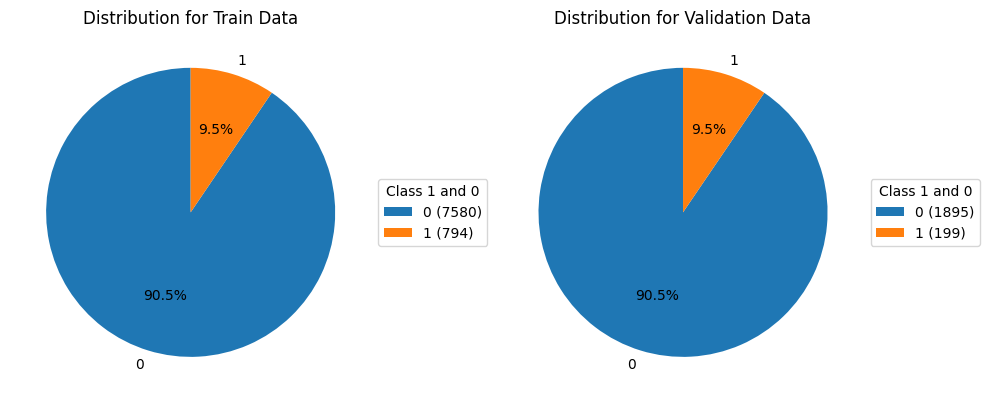

In [9]:
X_train, X_val, y_train, y_val = generate_data_splits(train_data)

pie_data_distributions([y_train, y_val], ['Train Data', 'Validation Data'])

## === Pre-processing ===

### Tokenization

In [10]:
from typing import List

def tokenize_text(text: List[str], tokenizer: BertTokenizer, max_length: int = 300):
    """Tokenize the input text using the provided tokenizer

    Args:
        text (List[str]): input text
        tokenizer (BertTokenizer): tokenizer to be used
        max_length (int, optional): maximum length of the tokenized text. Defaults to 300.

    Returns:
        dict: dictionary containing the tokenized text
    """    

    # We pad shorter sentences to a length of trunc_len tokens since the maximum sequence size for BERT is 512
    return tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

### 1. Masking Tokens

In [11]:
def mask_tokens(inputs, tokenizer, mlm_probability):
    """Given a tokenized input, will prepare masked tokens inputs/labels for Masked Language Modelling. 'We want to train BERT to predict an mlm_probability% of tokens (in the original paper it is 15%) of which 80% will be replaced by a ``[MASK]`` token, 10% with a random token and 10% remain the same token.' (from tutorial)

    Args:
        inputs (list): list of inputs to be masked
        tokenizer (BertTokenizer): tokenizer to be used
        mlm_probability (float): probability of applying a mask to each token

    Returns:
        (maksed tokens, original token): _description_
    """    

    assert tokenizer.mask_token is not None and "Tokenizer should not be none. (how can we mask if we don't know what to call it!)"

    labels = inputs.clone()

    # We sample a few tokens in each sequence for masked-LM training (with probability mlm_probability defaults to 0.15 in Bert/RoBERTa)
    probability_matrix = torch.full(labels.shape, mlm_probability)
    special_tokens_mask = [tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()]
    probability_matrix.masked_fill_(torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0)

    if tokenizer._pad_token is not None:
        padding_mask = labels.eq(tokenizer.pad_token_id)
        probability_matrix.masked_fill_(padding_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()
    labels[~masked_indices] = -100  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = tokenizer.convert_tokens_to_ids(tokenizer.mask_token)

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(len(tokenizer), labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

### 2. Stop Word Removal

explanation: https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a

we don't always remove stop words, e.g. https://www.ibm.com/docs/en/watson-explorer/11.0.0?topic=analytics-stop-word-removal when a sentence consists only of stop words, but this library takes care of it"Surprisingly, the stopwords received as much attention as non-stop words, but removing them has no effect in MRR performances." https://stackoverflow.com/questions/63633534/is-it-necessary-to-do-stopwords-removal-stemming-lemmatization-for-text-classif 

In [12]:
from gensim.parsing.preprocessing import remove_stopwords

# Another sample text
new_text = "I do not like you because I'm better than you"
 
# Remove stopwords using Gensim
new_filtered_text = remove_stopwords(new_text)

print("Original Text:", new_text)
print("Text after Stopword Removal:", new_filtered_text)

Original Text: I do not like you because I'm better than you
Text after Stopword Removal: I like I'm better


## === Data Sampling ===

### 1. "Easy Data Augmentation Techniques"

(Initially) Inspired by https://datascience.stackexchange.com/questions/27671/how-do-you-apply-smote-on-text-classification 

Code implemented from https://arxiv.org/pdf/1901.11196.pdf

In [13]:
!git clone https://github.com/jasonwei20/eda_nlp.git
from eda_nlp.code.eda import *

fatal: destination path 'eda_nlp' already exists and is not an empty directory.


In [14]:
# Default parameters have shown good performance in the original paper
eda("I hate you because I think that I'm better than you", alpha_ri=0.0, num_aug=5)

['i hatred you because i think that im better than you',
 'hate because i think that im better than you',
 'i because you hate i think that im better than you',
 'i hate you because i think that im better than you',
 'i hate you because i retrieve that im better than you',
 'i hate you because i think that im better than you']

In [55]:
def generate_eda(data, num_aug=3, probability=0.1):
    eda_upsampled = data[data['labels'] == 1]
    eda_upsampled.loc[:, 'text'] = eda_upsampled.apply(
        lambda row: eda(row['text']
                        , num_aug=num_aug
                        , alpha_ri=probability
                        , alpha_rs=probability
                        , p_rd    =probability
                        , alpha_sr=probability
                        ), axis=1) #alpha_ri=0.0, num_aug=num_aug), axis=1)

    upsampled_positives = pd.DataFrame(columns=data.columns)

    for _, row in eda_upsampled.iterrows():
        for upsample in row['text']:
            # insert into upsampled_positives the row['text'] and the remaining columns in variable row
            new_row = pd.DataFrame([row], columns=data.columns)
            new_row['text'] = upsample
            upsampled_positives = pd.concat([upsampled_positives, new_row], ignore_index=True)

    train_data_minority_upsampled = pd.concat([upsampled_positives, data[data['labels'] == 0]], ignore_index=True)

    return train_data_minority_upsampled

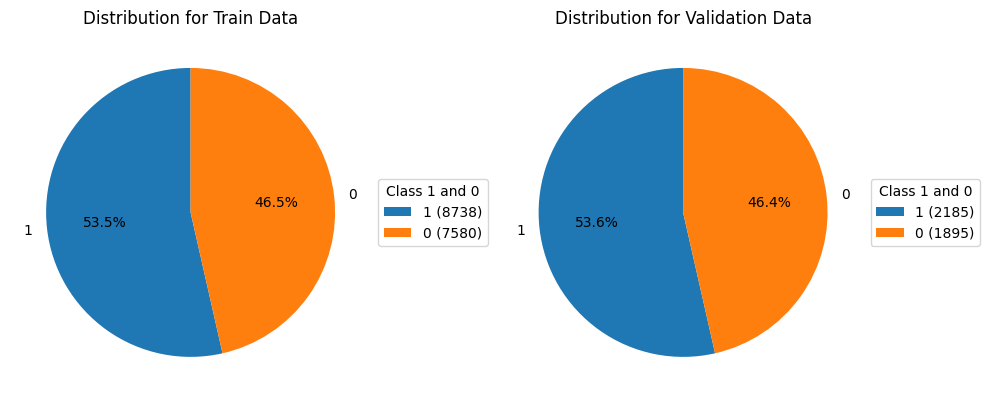

In [16]:
train_data_minority_upsampled = generate_eda(train_data, num_aug=10)

X_train, X_val, y_train, y_val = generate_data_splits(train_data_minority_upsampled)
pie_data_distributions([y_train, y_val], ['Train Data', 'Validation Data'])

### 2. Rephrasing

https://github.com/Vamsi995/Paraphrase-Generator

https://huggingface.co/Vamsi/T5_Paraphrase_Paws

Paraphrasing only really works on longer sentences

In [110]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

def paraphrase_text(text: str, num_return_sequences: int):
    """Paraphrase the input text using the T5 model

    Args:
        text (str): input text
        num_return_sequences (int): number of paraphrases to return

    Returns:
        list: list of paraphrased text
    """    

    # Format text for the model to understand the paraphrasing task
    text =  "paraphrase: " + text + " </s>"

    # Load model
    tokenizer = AutoTokenizer.from_pretrained("Vamsi/T5_Paraphrase_Paws")  
    model = AutoModelForSeq2SeqLM.from_pretrained("Vamsi/T5_Paraphrase_Paws").to('cuda')

    encoding = tokenizer.encode_plus(text, padding='longest', return_tensors="pt")
    input_ids, attention_masks = encoding["input_ids"].to("cuda"), encoding["attention_mask"].to("cuda")

    # Generate paraphrases
    outputs = model.generate(
        input_ids=input_ids, attention_mask=attention_masks,
        max_length=256,
        do_sample=True,
        top_k=120,
        top_p=0.95,
        early_stopping=True,
        num_return_sequences=num_return_sequences
    )

    # Decode the generated paraphrases
    return [tokenizer.decode(output, skip_special_tokens=True,clean_up_tokenization_spaces=True) for output in outputs]

for text in ["I don't like you because I'm better than you",
             "We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism ."]:
    for paraphrase in paraphrase_text(text, 5):
        print(paraphrase)

/home/avzh1/Documents/imperial/year4/lectures/nlp/Coursework/nlp/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:453: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


I don't like you because I'm better than you.
I don't like you because I'm better than you.
I don't like you because I'm better than you.
I don't like you because I am better than you.
I don't like you, because I am better than you.
For a while, waking up every day to check the news seemed to carry the same feeling of panic and dread that action heroes probably face when they decide whether to cut down the blue or green wire on a ticking bomb -- except the instructions of the bomb, long ago, burned in a fire and the imminent disaster seemed the probabilistic outcome.
We are living in times of absolute insanity, as most people are probably aware : waking every day to check the news seemed to carry with it the same feeling of panic and fear that action heroes might face when they decide whether to cut the blue or green wire on a ticking bomb, except the instructions of the bomb have burned long ago in a fire and the imminent catastrophe seems the likely outcome, so it's natural for peopl

### 3. Contextual Word Embeddings for Sentence Augmenter

https://github.com/makcedward/nlpaug/blob/master/example/textual_augmenter.ipynb

seems to be bad for long sentences, good for short!

In [119]:
# !pip install nlpaug

import nlpaug.augmenter.sentence as nas

aug = nas.ContextualWordEmbsForSentenceAug(model_path='distilgpt2')

for text in ["I don't like you because I'm better than you",
             "More than 750 trolleys of food donated to those in need",
             "The quick brown fox jumps over the lazy dog",
             "We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism ."]:
    print(aug.augment(text))


["I don't like you because I'm better than you I This A The , F The In ."]
['More than 750 trolleys of food donated to those in need I This to In The C You The to : The the It It " We This G " This , It to A D The of I T It']
['The quick brown fox jumps over the lazy dog The R A I The B .']
["We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism . M The I The A , and The the B W 1 ."]


### 4. AugGPT

https://github.com/yhydhx/AugGPT

### 5. Translate and back

https://github.com/NandhiniN85/Class-Imbalancing/blob/main/NLP%20-%20Class%20Imbalanced.ipynb

https://www.analyticsvidhya.com/blog/2020/11/handling-imbalanced-data-machine-learning-computer-vision-and-nlp/

In [128]:
# !pip install googletrans

# from googletrans import Translator # google translator doesn't seem to be working: issue: https://stackoverflow.com/questions/52455774/googletrans-stopped-working-with-error-nonetype-object-has-no-attribute-group/52456197#52456197

# translator = Translator()

# def Portugese_translation(x):
#     print(x)    
#     german_translation = translator.translate(x, dest='pt')    
#     return german_translation.text

# def English_translation(x):
#     print(x)    
#     english_translation = translator.translate(x, dest='en')    
#     return english_translation.text

# x = Portugese_translation("warning for using windows disk space")
# English_translation(x)

# !pip install -U deep-translator
from deep_translator import GoogleTranslator

def multi_translate(text):
    text = GoogleTranslator(source='en', target='pt').translate(text)
    text = GoogleTranslator(source='pt', target='ru').translate(text)
    return GoogleTranslator(source='ru', target='en').translate(text)

# multi_translate("More than 750 trolleys of food donated to those in need")

for text in ["I don't like you because I'm better than you",
             "More than 750 trolleys of food donated to those in need",
             "The quick brown fox jumps over the lazy dog",
             "We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism ."]:
    
    print(multi_translate(text))

I don't like you because I'm better than you
More than 750 food carts donated to those most in need
A fast brown fox jumps over a lazy dog
We live in a time of absolute madness, as I'm sure most people know. For a while, it seemed like waking up every day to check the news brought with it the same sense of panic and dread that action heroes probably face when trying to decide whether to cut the blue or green wire of a time bomb. except that the instructions for detonating the bomb have long since been burned in a fire, and imminent disaster appears to be the most likely outcome. However, it is difficult to remain nervous for so long, so it is only natural that people get used to this constant chaos and fall into the malaise of hopelessness and pessimism.


## === Model Setup ===

### Dataset Class

In [17]:
# Creating Datasets for formatting entries from the PCL dataset.
class PCLDataset(Dataset):
    def __init__(self, data_frame: pd.DataFrame
                 , tokenizer: BertTokenizer
                 , mask_tokens = False
                 , trunc_len = 300
                 , mlm_probability = 0.15):
        """Initializes the PCLDataset class"""

        self.data = data_frame
        self.tokenizer = tokenizer
        self.mask = mask_tokens
        self.trunc_len = trunc_len
        self.mlm_probability = mlm_probability        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """Returns a singular item with all pre-processing required for the tester"""

        # For now, we don't need the keyword and country_code

        # data = {'keyword'     : self.data['keyword'].iloc[idx],
        #         'country_code': self.data['country_code'].iloc[idx],
        #         'text'        : self.data['text'].iloc[idx]}
        
        data = {'text': self.data['text'].iloc[idx]}
        
        # instead of label and label_detailed we use label
        label = {'labels': self.data['labels'].iloc[idx]}

        return data, label
    
    def collate_fn(self, batch):
        """merges a list of samples to form a mini-batch of Tensor(s). Used when using batched loading from a map-style"""
        
        input_features = [i for i, _ in batch]
        output_labels  = [o for _, o in batch]

        # 1. Tokenize the input text
        batched_text = [item['text'] for item in input_features]
        encodings = tokenize_text(batched_text, self.tokenizer, self.trunc_len)

        # 2. Optionally mask the input
        # if self.mask:
        if False: # for now, we don't mask the input
            masked_input, labels = mask_tokens(encodings['input_ids'], self.tokenizer, self.mlm_probability)
            encodings['input_ids'] = masked_input
            encodings['labels'] = labels

        # 3. Process the output labels
        encodings['labels'] = torch.tensor([item['labels'] for item in output_labels])

        return encodings

### Data Sampling



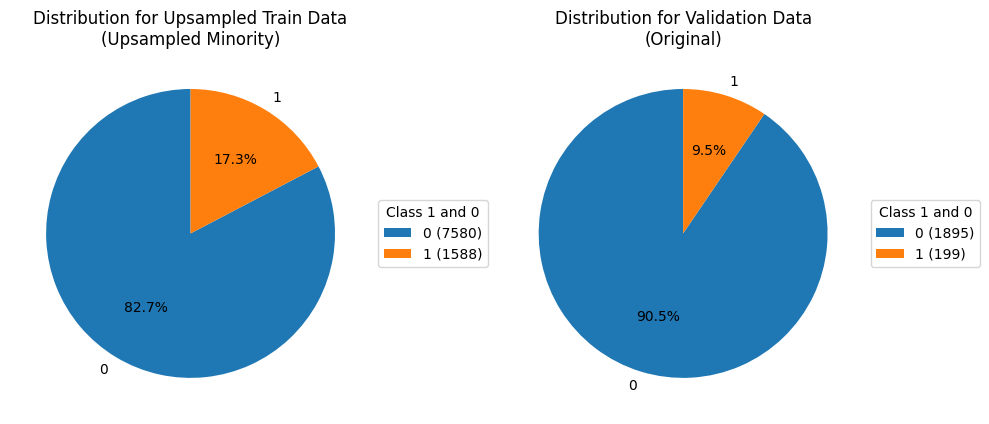

In [56]:
# Upsample the minority class

X_train, X_val, y_train, y_val = generate_data_splits(train_data)

sampled_train_data = pd.merge(X_train, y_train, left_index=True, right_index=True)
sampled_val_data = pd.merge(X_val, y_val, left_index=True, right_index=True)

# sampled_train_data = generate_eda(sampled_train_data, num_aug=1, probability=0.5)

pie_data_distributions([sampled_train_data['labels'], sampled_val_data['labels']], ['Upsampled Train Data\n(Upsampled Minority)', 'Validation Data\n(Original)'])

## === Model ===

In [39]:
h_params = {
      'text trunction length': 300
    , 'mask tokens': False
    , 'mlm probability': 0.15
    , 'batch size': 16
    , 'learning rate': 2e-5
    , 'epochs': 1
    , 'warmup steps': 100
    , 'weight decay': 0.01 
}

### Model Training Utils

In [40]:
def predict_hatespeech(input, tokenizer, model):
  model.eval()
  encodings = tokenizer(input, return_tensors='pt', padding=True, truncation=True, max_length=h_params['text trunction length'])
  encodings.to(DEVICE)

  output = model(**encodings)
  
  return torch.argmax(output.logits, dim=1)

In [41]:
def save_model_predictions(model_name, model, tokenizer):

    model.eval()

    # << create a dataloader for the entire training dataset >>
    global_train_dataset = PCLDataset(sampled_train_data, mask_tokens=h_params['mask tokens'], tokenizer=tokenizer, trunc_len=h_params['text trunction length'])
    global_train_data_loader = DataLoader(global_train_dataset, batch_size=h_params['batch size'], collate_fn=global_train_dataset.collate_fn)

    test_dataset = PCLDataset(test_data, mask_tokens=False, tokenizer=tokenizer, trunc_len=h_params['text trunction length'])
    test_data_loader = DataLoader(test_dataset, batch_size=h_params['batch size'], collate_fn=test_dataset.collate_fn)

    # << iterate through the dataloader and make predictions >>
    for loader in {global_train_data_loader, test_data_loader}:

        train_predictions = []

        with torch.no_grad():
            for batch in tqdm(loader):
                batch = batch.to(DEVICE)
                del batch['labels']
                
                logits = model(**batch)
                predictions = torch.argmax(logits.logits, dim=1)
                train_predictions.extend(predictions.tolist())

        train_predictions = np.array(train_predictions)

        if loader is global_train_data_loader:
            np.savetxt(f"{model_save_path}/{model_name}/dev.txt", train_predictions, fmt="%d")
        else:
            np.savetxt(f"{model_save_path}/{model_name}/test.txt", train_predictions, fmt="%d")


In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, tokenizer, data_loader):

  preds = []
  tot_labels = []

  with torch.no_grad():
    for logits, expected in tqdm(data_loader):
      
      tweets = logits['text']

      pred = predict_hatespeech(tweets, tokenizer, model)

      preds.append(pred.tolist())
      tot_labels.append(expected['labels'])

  # with the saved predictions and labels we can compute accuracy, precision, recall and f1-score
  report = classification_report(tot_labels, preds, target_names=["Not offensive","Offensive"], output_dict= True)

  cm = confusion_matrix(tot_labels, preds, labels=[0, 1]) 

  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True));  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')

  ax.set_title('Confusion Matrix')

  ax.xaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])
  ax.yaxis.set_ticklabels(['Not Patronizing', 'Patronizing'])

  plt.show()

  return report


In [43]:
import evaluate

def compute_accuracy(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = evaluate.load("accuracy")
    return metric.compute(predictions=predictions, references=labels)

In [91]:
def setup_trainer(model_name, model, h_params, training_dataset, val_dataset):

    #  << Set model to training mode >>
    model.train()

    # << Initilize the Training Arguments >>
    training_args = TrainingArguments(
          output_dir                 = model_name
        , learning_rate              = h_params['learning rate']
        , per_device_train_batch_size= h_params['batch size']
        , per_device_eval_batch_size = h_params['batch size']
        , num_train_epochs           = h_params['epochs']
        , weight_decay               = h_params['weight decay']
        , evaluation_strategy        = "epoch"
        , save_strategy              = "epoch"
        , load_best_model_at_end     = True
        , logging_dir                = f'{model_save_path}/{model_name}/logs'
        , logging_steps              = 10
    )

    # << Initilize the Trainer >>
    trainer = Trainer(
        model           = model,
        args            = training_args,
        train_dataset   = training_dataset,
        eval_dataset    = val_dataset,
        data_collator   = training_dataset.collate_fn,
        compute_metrics = compute_accuracy
    )

    return trainer

In [92]:
def plot_loss(trainer):
    log = trainer.state.log_history

    train_loss = []
    train_epoch = []

    eval_loss = [] # eval calculated at the end of each epoch
    eval_accuracy = []

    for log_entry in log:
        keys = log_entry.keys()

        if 'loss' in keys:
            train_loss.append(log_entry['loss'])
            train_epoch.append(log_entry['epoch'])
        elif 'eval_loss' in keys:
            eval_loss.append(log_entry['eval_loss'])
            eval_accuracy.append(log_entry['eval_accuracy'])
        
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot(train_epoch, train_loss, label='Training Loss')
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    eval_epoch = [i+1 for i in range(len(eval_loss))]

    print(eval_epoch)
    print(eval_loss)
    print(eval_accuracy)

    ax[1].plot(eval_epoch, eval_loss, 'x', label='Evaluation Loss')
    ax[1].plot(eval_epoch, eval_accuracy, 'o', label='Evaluation Accuracy')
    ax[1].set_title('Evaluation Loss and Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss and Accuracy')
    ax[1].legend()

    plt.show()

#### bert-base-cased

In [25]:
from transformers import BertTokenizer, AutoModelForSequenceClassification

# << Create Model and Tokenizer >>
model = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-cased', num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-cased')

# << Create Datasets >>
training_dataset = PCLDataset(sampled_train_data, mask_tokens=h_params['mask tokens'], tokenizer=tokenizer, trunc_len=h_params['text trunction length'])
val_dataset = PCLDataset(sampled_val_data, mask_tokens=h_params['mask tokens'], tokenizer=tokenizer, trunc_len=h_params['text trunction length'])

# << Setup the Trainer >> 
trainer = setup_trainer('bert-base-cased', model, h_params, training_dataset, val_dataset)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
train_output = trainer.train()
train_output

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anton-zhitomirsky (anton-zhitomirsky-joe-mama). Use `wandb login --relogin` to force relogin


  0%|          | 0/524 [00:00<?, ?it/s]

{'loss': 0.4909, 'grad_norm': 3.369955062866211, 'learning_rate': 1.9618320610687024e-05, 'epoch': 0.02}
{'loss': 0.2792, 'grad_norm': 2.849342107772827, 'learning_rate': 1.923664122137405e-05, 'epoch': 0.04}
{'loss': 0.434, 'grad_norm': 2.597923755645752, 'learning_rate': 1.885496183206107e-05, 'epoch': 0.06}
{'loss': 0.223, 'grad_norm': 1.6608695983886719, 'learning_rate': 1.847328244274809e-05, 'epoch': 0.08}
{'loss': 0.3377, 'grad_norm': 2.6354997158050537, 'learning_rate': 1.8091603053435117e-05, 'epoch': 0.1}
{'loss': 0.2623, 'grad_norm': 2.506601095199585, 'learning_rate': 1.770992366412214e-05, 'epoch': 0.11}
{'loss': 0.3264, 'grad_norm': 3.891265630722046, 'learning_rate': 1.7328244274809162e-05, 'epoch': 0.13}
{'loss': 0.3718, 'grad_norm': 4.210970878601074, 'learning_rate': 1.6946564885496184e-05, 'epoch': 0.15}
{'loss': 0.2097, 'grad_norm': 3.398803234100342, 'learning_rate': 1.6564885496183207e-05, 'epoch': 0.17}
{'loss': 0.2518, 'grad_norm': 5.178341865539551, 'learning_r

  0%|          | 0/131 [00:00<?, ?it/s]

Checkpoint destination directory bert-base-cased/checkpoint-524 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.20899520814418793, 'eval_accuracy': 0.9164278892072588, 'eval_runtime': 7.8278, 'eval_samples_per_second': 267.509, 'eval_steps_per_second': 16.735, 'epoch': 1.0}
{'train_runtime': 101.3115, 'train_samples_per_second': 82.656, 'train_steps_per_second': 5.172, 'train_loss': 0.25637817087064263, 'epoch': 1.0}


TrainOutput(global_step=524, training_loss=0.25637817087064263, metrics={'train_runtime': 101.3115, 'train_samples_per_second': 82.656, 'train_steps_per_second': 5.172, 'train_loss': 0.25637817087064263, 'epoch': 1.0})

100%|██████████| 2094/2094 [00:08<00:00, 238.93it/s]


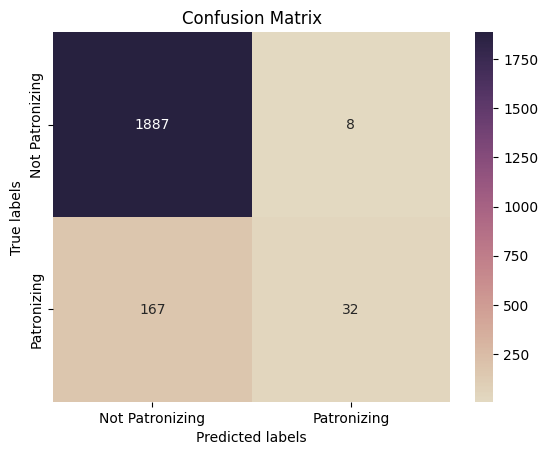

{'Not offensive': {'precision': 0.9186952288218111,
  'recall': 0.995778364116095,
  'f1-score': 0.9556849835401368,
  'support': 1895.0},
 'Offensive': {'precision': 0.8,
  'recall': 0.16080402010050251,
  'f1-score': 0.26778242677824265,
  'support': 199.0},
 'accuracy': 0.9164278892072588,
 'macro avg': {'precision': 0.8593476144109056,
  'recall': 0.5782911921082987,
  'f1-score': 0.6117337051591897,
  'support': 2094.0},
 'weighted avg': {'precision': 0.9074152142394135,
  'recall': 0.9164278892072588,
  'f1-score': 0.8903112448602815,
  'support': 2094.0}}

In [27]:
evaluate_model(model, tokenizer, val_dataset)
# trainer.evaluate()

In [33]:
save_model_predictions('bert-base-cased', model, tokenizer)

100%|██████████| 524/524 [00:32<00:00, 15.92it/s]


#### roberta

In [93]:
from transformers import RobertaTokenizer, AutoModelForSequenceClassification

# << Create Model and Tokenizer >>
model = AutoModelForSequenceClassification.from_pretrained('FacebookAI/roberta-base', num_labels=2, id2label=id2label, label2id=label2id)
tokenizer = RobertaTokenizer.from_pretrained('FacebookAI/roberta-base')

# << Create Datasets >>
training_dataset = PCLDataset(sampled_train_data, mask_tokens=h_params['mask tokens'], tokenizer=tokenizer, trunc_len=h_params['text trunction length'])
val_dataset = PCLDataset(sampled_val_data, mask_tokens=False, tokenizer=tokenizer, trunc_len=h_params['text trunction length'])

# << Setup the Trainer >> 
trainer = setup_trainer('roberta-base', model, h_params, training_dataset, val_dataset)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [90]:
train_output = trainer.train()
train_output

  0%|          | 0/573 [00:00<?, ?it/s]

{'loss': 0.5466, 'grad_norm': 3.582944631576538, 'learning_rate': 1.9650959860383945e-05, 'epoch': 0.02}


  0%|          | 0/131 [00:00<?, ?it/s]

{'eval_loss': 0.33274728059768677, 'eval_accuracy': 0.9049665711556829, 'eval_runtime': 8.1413, 'eval_samples_per_second': 257.208, 'eval_steps_per_second': 16.091, 'epoch': 0.02}
{'loss': 0.2953, 'grad_norm': 3.8743176460266113, 'learning_rate': 1.930191972076789e-05, 'epoch': 0.03}


  0%|          | 0/131 [00:00<?, ?it/s]

{'eval_loss': 0.43497857451438904, 'eval_accuracy': 0.9049665711556829, 'eval_runtime': 7.7575, 'eval_samples_per_second': 269.933, 'eval_steps_per_second': 16.887, 'epoch': 0.03}
{'loss': 0.1607, 'grad_norm': 1.2727198600769043, 'learning_rate': 1.895287958115183e-05, 'epoch': 0.05}


  0%|          | 0/131 [00:00<?, ?it/s]

KeyboardInterrupt: 

100%|██████████| 2094/2094 [00:17<00:00, 117.48it/s]


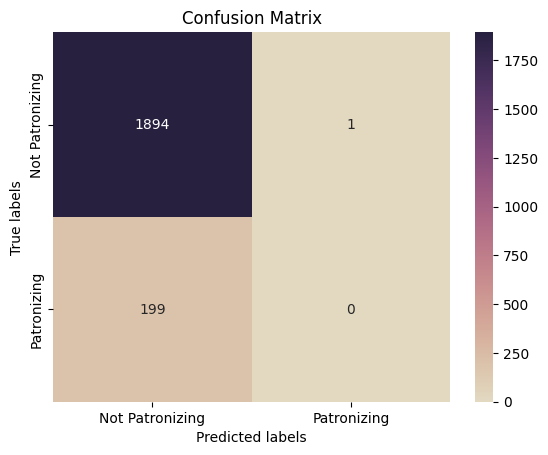

100%|██████████| 9168/9168 [01:09<00:00, 132.30it/s]


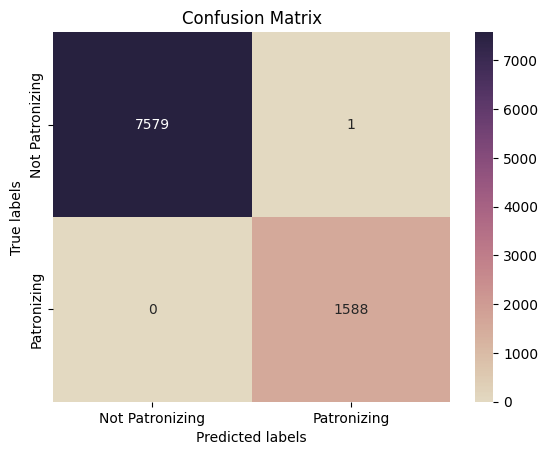

{'Not offensive': {'precision': 1.0,
  'recall': 0.999868073878628,
  'f1-score': 0.9999340325879016,
  'support': 7580.0},
 'Offensive': {'precision': 0.9993706733794839,
  'recall': 1.0,
  'f1-score': 0.9996852376455776,
  'support': 1588.0},
 'accuracy': 0.99989092495637,
 'macro avg': {'precision': 0.999685336689742,
  'recall': 0.9999340369393139,
  'f1-score': 0.9998096351167396,
  'support': 9168.0},
 'weighted avg': {'precision': 0.9998909936001985,
  'recall': 0.99989092495637,
  'f1-score': 0.9998909385250295,
  'support': 9168.0}}

In [59]:
evaluate_model(model, tokenizer, val_dataset)
evaluate_model(model, tokenizer, training_dataset)

In [37]:
save_model_predictions('roberta-base', model, tokenizer)

100%|██████████| 240/240 [00:12<00:00, 19.16it/s]
